# SGD Update Visualization for Single Parameter

Interactive plot of SGD updates for a single parameter. The gradients for the parameter are random values with a standard normal distribution. The following arguments to SGD can be interactively modified:
- learning rate    
- learning rate linear decay step size
- momentum
- gradient clip value

In [1]:
%matplotlib notebook

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider

In [2]:
class SGD(object):
    """Calculate single paramter SGD updates with optional momentum."""
    
    def __init__(self, momentum=0):
        self.momentum = momentum
        self.prev_update = 0
    
    def update(self, gradient, lr):
        """Returns SGD update for single parameter.
        
        # Arguments
            gradient: float
            lr: float, learning rate
        """
        
        update = self.momentum * self.prev_update - lr * gradient
        self.prev_update = update
        return update   

<IPython.core.display.Javascript object>


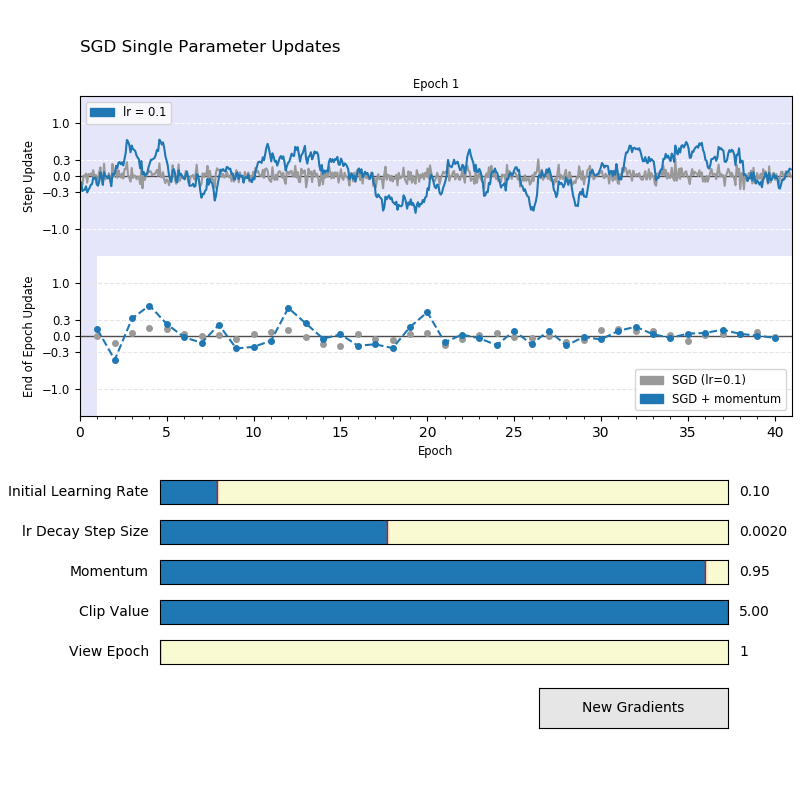

In [3]:
# initial conditions
lr = 0.1 # used for vanilla SGD too
decay_step = 2e-03
momentum = 0.95
clip_value = 5.0
view_epoch = 1

# static
epochs = np.arange(1, 41, 1)
steps_per_epoch = np.arange(1, 592, 1)
iterations = len(epochs) * len(steps_per_epoch) # same as 40 epochs of MNIST with batch size 64

plt.rcParams['figure.figsize'] = (8.0, 8.0)
fig, ax = plt.subplots(nrows=2)
plt.subplots_adjust(left=0.1, right=0.99, bottom=0.48, hspace=0)

ax[0].axis([steps_per_epoch[0] - 1, steps_per_epoch[-1] + 1, -1.5, 1.5])
ax[0].set_facecolor('lavender')
ax[0].grid(axis='y', color='0.99', linestyle='--')
ax[0].hlines(0, 0, len(steps_per_epoch) + 1, color='0.3', linewidth=1)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_yticks([-1, -0.3, 0, 0.3, 1]) # place ticks at 3 standard deviations
ax[0].set_ylabel('Step Update', fontsize='small')
ax[0].tick_params(bottom=False, labelbottom=False, labelsize='small')

ax[1].axis([epochs[0] - 1, epochs[-1] + 1, -1.5, 1.5])
ax[1].grid(axis='y', color='0.9', linestyle='--')
ax[1].hlines(0, 0, len(epochs) + 1, color='0.3', linewidth=1)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('Epoch', fontsize='small')
ax[1].set_xticks(epochs, minor=True)
ax[1].set_yticks([-1, -0.3, 0, 0.3, 1], ) # place ticks at 3 standard deviations
ax[1].set_ylabel('End of Epoch Update', fontsize='small')
ax[1].tick_params(axis='y', labelsize='small')

# updatable
view_rect = ax[1].axvspan(view_epoch - 1, view_epoch, facecolor='lavender')
gradients = np.random.normal(size=iterations)
lrs = [np.maximum(lr - decay_step * (i // 591), 0.001) for i in range(iterations)] # learning rate linear decay

sgd = SGD()
updates = [sgd.update(g, lr) for g in gradients]
vs_steps, = ax[0].plot(
    steps_per_epoch, updates[591*(view_epoch-1):591*view_epoch], 
    color='0.6', label='SGD (lr=' + str(lr) + ')')
vs_epochs, = ax[1].plot(
    epochs, updates[590::591], 
    color='0.6', linestyle='None', marker='o', markersize=4, 
    label='SGD (lr=' + str(lr) + ')')

sgd = SGD(momentum=momentum)
updates = [sgd.update(g, lr) for g, lr in zip(np.clip(gradients, -clip_value, clip_value), lrs)]
sm_steps, = ax[0].plot(
    steps_per_epoch, updates[591*(view_epoch-1):591*view_epoch], 
    label='SGD + momentum')
sm_epochs, = ax[1].plot(
    epochs, updates[590::591], 
    linestyle='--', marker='o', markersize=4, 
    label='SGD + momentum')

# legends
lr_patch = mpatches.Patch(color=sm_epochs.get_color(), label="lr = " + str(lrs[view_epoch]))
ax[0].legend(handles=[lr_patch], loc='upper left', fontsize='small')
ax[0].set_title("Epoch " + str(view_epoch), fontsize='small')
vs_patch = mpatches.Patch(color=vs_epochs.get_color(), label='SGD (lr=' + str(lr) + ')')
sm_patch = mpatches.Patch(color=sm_epochs.get_color(), label='SGD + momentum')
ax[1].legend(handles=[vs_patch, sm_patch], loc='lower right', fontsize='small')

# controls
axcolor = 'lightgoldenrodyellow'
top = 0.42
slider_width = 0.71

ax_lr = plt.axes([0.2, top - 0.05, slider_width, 0.03], facecolor=axcolor)
ax_decay_step = plt.axes([0.2, top - 2*0.05, slider_width, 0.03], facecolor=axcolor)
ax_momentum = plt.axes([0.2, top - 3*0.05, slider_width, 0.03], facecolor=axcolor)
ax_clip = plt.axes([0.2, top - 4*0.05, slider_width, 0.03], facecolor=axcolor)
ax_epoch = plt.axes([0.2, top - 5*0.05, slider_width, 0.03], facecolor=axcolor)
ax_grad = plt.axes([0.2 + 2 * slider_width / 3, top - 6*0.05 - 0.03, slider_width / 3, 0.05], facecolor=axcolor)

s_lr = Slider(ax_lr, 'Initial Learning Rate', 0.0, 1.0, valstep=0.01, valinit=lr)
s_decay_step = Slider(ax_decay_step, 'lr Decay Step Size', 0.0, 5e-3, valstep=1e-4, valinit=decay_step, valfmt='%1.4f')
s_momentum = Slider(ax_momentum, 'Momentum', 0.0, 0.99, valstep=0.01, valinit=momentum)
s_clip = Slider(ax_clip, 'Clip Value', 0.5, 5, valstep=0.5, valinit=clip_value)
s_epoch = Slider(ax_epoch, 'View Epoch', 1, len(epochs), valstep=1, valinit=view_epoch, valfmt='%d')
b_grad = Button(ax_grad, 'New Gradients', color='0.9', hovercolor='0.8')

def new_gradients(val):
    global gradients 
    gradients = np.random.normal(size=iterations)
    update_view(val)    
    
def update_view(val):
    l = s_lr.val
    m = s_momentum.val
    d = s_decay_step.val
    c = s_clip.val
    e = int(s_epoch.val)
    
    view_rect.get_xy()[:,0] = [e-1, e-1, e, e, e-1]
    
    sgd = SGD()
    updates = [sgd.update(g, lr) for g in gradients]
    vs_epochs.set_ydata(updates[590::591])
    vs_steps.set_ydata(updates[591*(e-1):591*e])
    
    sgd = SGD(momentum=m)
    lrs = [np.maximum(l - d * (i // 591), 0.001) for i in range(len(gradients))]
    lr_patch.set_label("lr = " + str(round(lrs[591*(e-1)], 4)))
    ax[0].legend(handles=[lr_patch], loc='upper left', fontsize='small')
    ax[0].set_title("Epoch " + str(e), fontsize='small')
    updates = [sgd.update(g, lr) for g, lr in zip(np.clip(gradients, -c, c), lrs)]
    sm_epochs.set_ydata(updates[590::591])
    sm_steps.set_ydata(updates[591*(e-1):591*e])
    
    fig.canvas.draw_idle()        
  
s_lr.on_changed(update_view)
s_decay_step.on_changed(update_view)
s_momentum.on_changed(update_view)
s_clip.on_changed(update_view)
s_epoch.on_changed(update_view)
b_grad.on_clicked(new_gradients)

plt.suptitle('SGD Single Parameter Updates', x=0.1, y=0.95, ha='left')
plt.show()

### Notes
- The graphs show value of the update that will be applied to the parameter. They don't show the actual value of the parameter. 
- Gradients for the parameter are random values with a standard normal distribution.
- There are 591 steps per epoch.
- Decay step size is subtracted from the learning rate at the end of each epoch.
- Clip value of 5 is basically the same as no clip value, since gradients have a standard normal distribution.
- 99.7% of SGD updates with a learning rate of 0.1 are between &plusmn;0.3 (3 standard deviations away from the mean SGD update with a learning rate of 0.1). The gridlines at &plusmn;0.3 give a sense of how momentum can cause SGD to explore more of the solution space.
- End of epoch updates give a sense of the effects of decay but are probably not useful otherwise.